In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/UrbanSound8K/slices_2d/slice_2d_filenames.csv')
df.head()

,Unnamed: 0,file_path,classid
0,0,../data/UrbanSound8K/slices_2d/fold1/46654-6-0...,6
1,1,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0
2,2,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0
3,3,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0
4,4,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0


In [3]:
len(df['classid'].unique())

10

In [4]:
df['fold'] = [int(text[-2][-1]) for text in df['file_path'].str.split('/')]

In [5]:
df.head()

,Unnamed: 0,file_path,classid,fold
0,0,../data/UrbanSound8K/slices_2d/fold1/46654-6-0...,6,1
1,1,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1
2,2,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1
3,3,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1
4,4,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1


In [6]:
class UrbanSoundDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = np.load(row['file_path'])
        x = torch.tensor(x).float()
        y = torch.tensor(row['classid'])
        return x, y
        

In [7]:
df_train = df[df['fold'] < 8]

In [8]:
df_val = df.drop(df_train.index)

In [9]:
df_train.shape[0], df_val.shape[0], df.shape[0]

(36175, 8100, 44275)

In [10]:
ds_train = UrbanSoundDataset(df_train)
ds_val = UrbanSoundDataset(df_val)
dl_train = DataLoader(ds_train, batch_size=1000, shuffle=True)
dl_val = DataLoader(ds_train, batch_size=500, shuffle=False)

In [11]:
next(iter(ds_train))[0].shape

torch.Size([32, 16, 2])

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        
        self.linear1 = nn.Linear(512, 100)
        self.linear2 = nn.Linear(100, 10)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.flatten = nn.Flatten()
        
        self.dropout = nn.Dropout2d(p=0.2)
        
        
    def forward(self, x):
        # helpful to do this along the way sometimes!
        #print(x.shape)
        
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.pool(x)

        x = self.dropout(x)
        x = self.flatten(x)
        
        # unroll x for FC layer
        x = self.linear1(self.flatten(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

In [13]:
model = CNN()
from torchsummary import summary
summary(model, input_size = (32, 16, 2), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 17, 3]           8,256
              Tanh-2            [-1, 64, 17, 3]               0
         MaxPool2d-3             [-1, 64, 8, 1]               0
            Conv2d-4            [-1, 128, 9, 2]          32,896
              Tanh-5            [-1, 128, 9, 2]               0
         MaxPool2d-6            [-1, 128, 4, 1]               0
         Dropout2d-7            [-1, 128, 4, 1]               0
           Flatten-8                  [-1, 512]               0
           Flatten-9                  [-1, 512]               0
           Linear-10                  [-1, 100]          51,300
             ReLU-11                  [-1, 100]               0
           Linear-12                   [-1, 10]           1,010
Total params: 93,462
Trainable params: 93,462
Non-trainable params: 0
---------------------------------

In [14]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_acc = []
    
    softmax = nn.Softmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        acc = 1 - (torch.count_nonzero(y - y_pred).item() / y.shape[0])
        
        total_acc.append(acc)
        
    return round(np.mean(total_acc),2)

In [15]:
from tqdm.notebook import tqdm
def train_epoch(num_epochs, model, dl_train, dl_val, optimizer, lossFun, ds_train, ds_val):
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in tqdm(range(num_epochs)):
        print('Epoch: ', epoch)

        train_loss = one_pass(model, dl_train, optimizer, lossFun)
        train_losses.append(train_loss)
        print('Train loss: ', train_loss)

        valid_loss = one_pass(model, dl_val, optimizer, lossFun, backwards=False)
        valid_losses.append(valid_loss)
        print('Valid loss: ', valid_loss)

        train_acc = one_pass_acc(model, dl_train, len(ds_train))
        train_accs.append(train_acc)
        valid_acc = one_pass_acc(model, dl_val, len(ds_val))
        valid_accs.append(valid_acc)
        print('Train Acc: ', train_acc)
        print('Valid Acc: ', valid_acc)
    
    return train_losses, valid_losses, train_accs, valid_accs
    

In [16]:
import seaborn as sns

In [17]:
def plot_results(train_loss, val_loss, train_acc, val_acc):
    sns.set_theme()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Losses')
    axes[0].legend()
    
    axes[1].plot(train_acc, label='train')
    axes[1].plot(val_acc, label='validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.show()

In [18]:
ds_train = UrbanSoundDataset(df_train)
ds_val = UrbanSoundDataset(df_val)
dl_train = DataLoader(ds_train, batch_size=100, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=100, shuffle=False)

In [19]:
num_epoch = 10
model = CNN()
dl_train = dl_train
dl_val = dl_val
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
lossFun = nn.CrossEntropyLoss()
ds_train = ds_train
ds_val = ds_val

train_losses, valid_losses, train_accs, valid_accs = train_epoch(num_epoch, model, dl_train, dl_val, optimizer, lossFun, ds_train, ds_val)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.7312265736622046


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.6105207675769004
Train Acc:  0.47
Valid Acc:  0.37
Epoch:  1


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.2968530223514494


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.5337809640684246
Train Acc:  0.59
Valid Acc:  0.49
Epoch:  2


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.0717233091757443


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.5579914796499559
Train Acc:  0.67
Valid Acc:  0.54
Epoch:  3


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.9168297072141869


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.7268256817334964
Train Acc:  0.72
Valid Acc:  0.53
Epoch:  4


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.7999589242329255


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.6764434737923704
Train Acc:  0.77
Valid Acc:  0.56
Epoch:  5


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.7064347342068319


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.7236124001167439
Train Acc:  0.79
Valid Acc:  0.56
Epoch:  6


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.6344079138165679


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.7584843043191933
Train Acc:  0.82
Valid Acc:  0.54
Epoch:  7


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.5728066236768639


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.9087321666287786
Train Acc:  0.84
Valid Acc:  0.54
Epoch:  8


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.5168848090408915


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.8813699454437067
Train Acc:  0.85
Valid Acc:  0.54
Epoch:  9


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.47489824479456105


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.937306711703171
Train Acc:  0.87
Valid Acc:  0.54


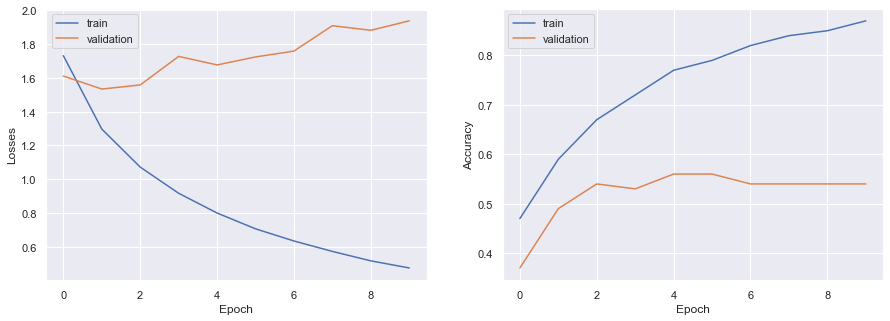

In [20]:
plot_results(train_losses, valid_losses, train_accs, valid_accs)

In [21]:
def plot_results(train_loss, val_loss, train_acc, val_acc, save=False):
    sns.set_theme()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Losses')
    axes[0].legend()
    
    axes[1].plot(train_acc, label='train')
    axes[1].plot(val_acc, label='validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    if save:
        plt.savefig('3d', dpi=150)

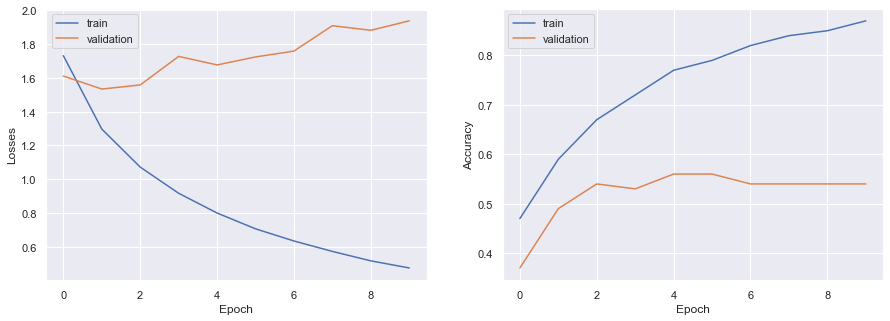

In [22]:
plot_results(train_losses, valid_losses, train_accs, valid_accs, save=True)